In [33]:
from openai import OpenAI
import os
import base64
import pprint

This Python script is designed to automate the process of encoding images and generating keystrokes for a GUI (Graphical User Interface) manipulation task. It uses the OpenAI API to generate the keystrokes based on the images provided.

Here's a detailed breakdown of the code:

1. The encode_image function is defined. This function takes an image path as an argument, opens the image file in binary mode, reads the file, encodes it in base64, and then decodes it to UTF-8. The result is a base64 string representation of the image.

2. The properties_dir variable is set to the relative path of the 'properties' directory. The script assumes that this directory is in the same location as the script itself.

3. The property_dirs list is populated with all directories in the 'properties' directory.

4. The all_messages list is initialized to store all messages that will be sent to the OpenAI API.

5. A system prompt message is created and appended to the all_messages list. This message describes the task that the AI is supposed to perform.

6. The GUI image is encoded using the encode_image function and a user message containing the encoded image and some text instructions is created and appended to the all_messages list.

7. The script then loops through each directory in the 'properties' directory. For each directory, it:

- Constructs the full directory path.
- Gets all files in the directory.
- Finds the 'events' file (a file starting with 'events-') and the image file (a file ending with '.png').
- If both files are found, it opens the 'events' file, extracts the keylog, encodes the image, and appends both the user message with the encoded image and the assistant message with the keylog to the all_messages list.

Assumptions:

- The script assumes that the 'properties' directory is in the same location as the script itself.
- It assumes that each subdirectory in the 'properties' directory contains an 'events' file and a '.png' image file.
- The 'events' file is expected to contain a keylog, which is a record of keys pressed by the user.
- The image file is expected to be a PNG image of the GUI that the AI is supposed to manipulate.
- The script also assumes that the OpenAI API can generate the correct keystrokes based on the images and keylogs provided.

In [119]:
import os
import base64

# Function to encode image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Assuming 'properties' folder is in the same directory as your script
properties_dir = './properties'

# Get all directories in the 'properties' folder
property_dirs = [d for d in os.listdir(properties_dir) if os.path.isdir(os.path.join(properties_dir, d))]

# Initialize an empty list to store all messages
all_messages = []

system_prompt =  {
            "role": "system",
            "content": [
                {"type": "text", "text": "You are a keyboard automation AI. You generate keystrokes which can be replayed into an application to accomplish a task. You don't have knowledge of the downstream application or task, except what you've gotten from the image, so you must rely on patterns in the keystroke examples provided in the conversation so far. Given an image, return the keystrokes that should be associated with it."}],
}

    

all_messages.append(system_prompt)

encoded_gui = encode_image('gui.png')


all_messages.append({
    "role": "user",
    "content": [
        {
            "type": "text",
            "text": """Your task involves manipulating this GUI. You will be given just the image and need to successfully manipulate the GUI using traces of keystrokes. Here are the locations of elements on the screen.
1511 x 981 height and width of screen
Control locations
Enter real-world distance: 628, 730

Start scale: 730, 730
Set scale: 830, 730
Calculate distances: 930, 730
Calculate area: 10150, 730
Predominant pitch: 1180, 730

Top left image corner: 375, 105
Top right image corner: 1175, 105
Bottom right image corner: 1175, 704
Bottom left image corner: 375, 704"""
        },
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/png;base64,{encoded_gui}"
            }
        }
    ],
})


# Loop through each directory
for dir in property_dirs:
    # Construct full directory path
    dir_path = os.path.join(properties_dir, dir)
    
    # Get all files in the directory
    files = os.listdir(dir_path)
    
    # Find the events file
    events_file = next((f for f in files if f.startswith('events-')), None)
    # Find the image file
    image_file = next((f for f in files if f.endswith('.png')), None)
    
    if events_file and image_file:
        # Construct full file paths
        events_file_path = os.path.join(dir_path, events_file)
        image_file_path = os.path.join(dir_path, image_file)
        
        # Open the events file and extract keylog
        with open(events_file_path, 'r') as f:
            keylog = f.read().strip()
        
        # Encode the image
        encoded_image = encode_image(image_file_path)
        
        # Add the user message with the encoded image
        all_messages.append({
            "role": "user",
            "content": [{
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/png;base64,{encoded_image}"
                }
            }],
        })

        # Add the assistant message with the keylog
        all_messages.append({
            "role": "assistant",
            "content": ["{0}".format(keylog)],
        })

Same as the above, but for testing against holdout images

In [120]:
test_dir = './test'
test_image = next((f for f in os.listdir(test_dir) if f.endswith('.png')), None)
encoded_test_image = encode_image(os.path.join(test_dir, test_image))
all_messages.append({
    "role": "user",
    "content": [{
        "type": "image_url",
        "image_url": {
            "url": f"data:image/png;base64,{encoded_test_image}"
        }
    }],
})

{'role': 'user',
 'content': [{'type': 'text',
   'text': 'Your task involves manipulating this GUI. You will be given just the image and need to successfully manipulate the GUI using traces of keystrokes. Here are the locations of elements on the screen.\n1511 x 981 height and width of screen\nControl locations\nEnter real-world distance: 628, 730\n\nStart scale: 730, 730\nSet scale: 830, 730\nCalculate distances: 930, 730\nCalculate area: 10150, 730\nPredominant pitch: 1180, 730\n\nTop left image corner: 375, 105\nTop right image corner: 1175, 105\nBottom right image corner: 1175, 704\nBottom left image corner: 375, 704'},
  {'type': 'image_url',
   'image_url': {'url': ''}}]}
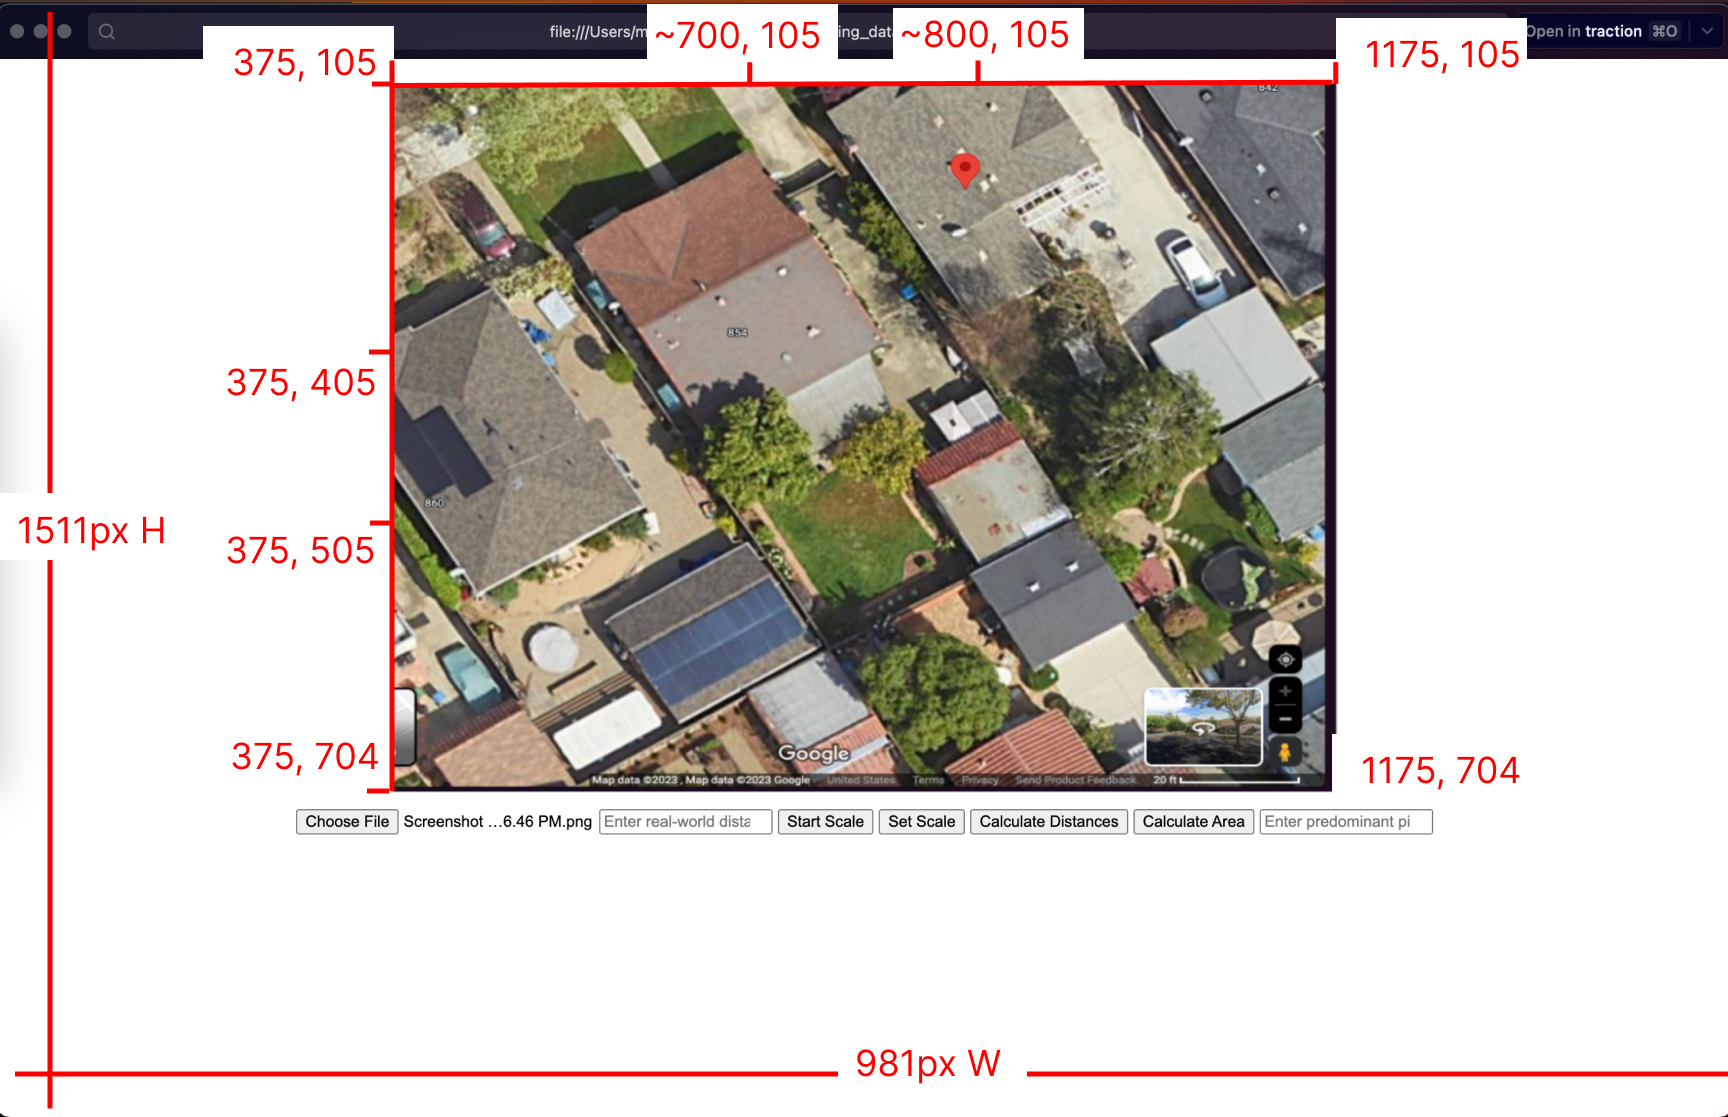

In [122]:
all_messages[1]

In [132]:

client = # OPENAI CLIENT WITH YOUR API KEY HERE

response = client.chat.completions.create(
  model="gpt-4-vision-preview",
    messages=all_messages,
    max_tokens=2000,
)

In [131]:
# updating based on feedback
all_messages.append({
    "role": "assistant",
    "content": ["{0}".format(response.choices[0].message.content)],
})
update_dir = './update'
update_image = next((f for f in os.listdir(update_dir) if f.endswith('.png')), None)
encoded_update_image = encode_image(os.path.join(test_dir, test_image))

all_messages.append({
    "role": "user",
    "content": [
        {
            "type": "text",
            "text": "That wasn't quite right. Look at the output and provide a better set of keystrokes."
        },
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/png;base64,{encoded_update_image}"
            }
        }
    ],
})

In [107]:
len(all_messages)
# all_messages = all_messages[:-2]

In [133]:
response.choices[0].message.content

'I apologize for the oversight. Based on your instructions, let\'s correct the keystrokes for the interface:\n\n1. Click the "Enter real-world distance" box.\n2. Enter the sample distance number (for example, "100").\n3. Click the "Start Scale" button to begin scale marking.\n4. Mark two points on the image to establish the scale using the mouse clicks. (Let\'s assume the points are at the corners of a house or a known distance on the image.)\n5. Click the "Set Scale" button after marking the points.\n6. Click the "Calculate distances" button to process the scale and calculate distances.\n\nHere is a new set of corrected keystrokes and mouse actions:\n\n```json\n[\n    {"type": "mouse", "x": 628, "y": 730, "button": "Button.left", "action": "press"},\n    {"type": "mouse", "x": 628, "y": 730, "button": "Button.left", "action": "release"},\n    {"type": "keyboard", "key": "100", "action": "press"},\n    {"type": "keyboard", "key": "100", "action": "release"},\n    {"type": "mouse", "x":

In [134]:
# Get the content from the response
content = response.choices[0].message.content

# Define the path to the output file
output_file_path = os.path.join(test_dir, 'event-test.txt')

# Write the content to the file
with open(output_file_path, 'w') as f:
    f.write(content)